# CA10: Model-Based Reinforcement Learning and Planning Methods

## Deep Reinforcement Learning - Session 10

**Comprehensive Coverage of Model-Based Reinforcement Learning**

This notebook provides a complete exploration of model-based reinforcement learning, covering theoretical foundations, planning algorithms, and practical implementations of various model-based approaches including Dyna-Q, Monte Carlo Tree Search (MCTS), Model Predictive Control (MPC), and modern neural approaches.

### Learning Objectives:
1. Understand the theoretical foundations of model-based reinforcement learning
2. Implement classical planning algorithms: Dynamic Programming, Value Iteration
3. Explore integrated planning and learning: Dyna-Q algorithm
4. Master Monte Carlo Tree Search (MCTS) and its applications
5. Implement Model Predictive Control (MPC) for continuous control
6. Understand modern neural model-based approaches
7. Compare model-based vs model-free methods
8. Apply model-based methods to complex environments

### Notebook Structure:
1. **Theoretical Foundations** - Model-based RL theory and framework
2. **Environment Models** - Learning and representing environment dynamics
3. **Classical Planning** - Dynamic Programming and Value Iteration with learned models
4. **Dyna-Q Algorithm** - Integrating planning and learning
5. **Monte Carlo Tree Search** - MCTS algorithm and applications
6. **Model Predictive Control** - MPC for continuous control problems
7. **Modern Neural Methods** - World models and neural planning
8. **Comparative Analysis** - Model-based vs model-free comparison



<!-- vscode-jupyter-toc-config {"maxdepth":2, "orderedList": false} -->

<a id="toc-start"></a>

## Table of Contents

- [Section 1: Theoretical Foundations](#section-1-theoretical-foundations)
- [Section 2: Environment Models](#section-2-environment-models)
- [Section 3: Classical Planning (with Learned Models)](#section-3-classical-planning-with-learned-models)
- [Section 4: Dyna-Q Algorithm](#section-4-dyna-q)
- [Section 5: Monte Carlo Tree Search (MCTS)](#section-5-monte-carlo-tree-search-mcts)
- [Section 6: Model Predictive Control (MPC)](#section-6-model-predictive-control-mpc)
- [Section 7: Advanced Model-Based Methods & Modern Approaches](#section-7-advanced-model-based-methods-and-modern-approaches)
- [Section 8: Comparative Analysis & Demonstrations](#comprehensive-model-based-rl-comparison-and-analysis)

<!-- Explicit HTML anchors (helps VS Code/Jupyter TOC and direct linking) -->
<a id="section-1-theoretical-foundations"></a>
<a id="section-2-environment-models"></a>
<a id="section-3-classical-planning-with-learned-models"></a>
<a id="section-4-dyna-q"></a>
<a id="section-5-monte-carlo-tree-search-mcts"></a>
<a id="section-6-model-predictive-control-mpc"></a>
<a id="section-7-advanced-model-based-methods-and-modern-approaches"></a>
<a id="comprehensive-model-based-rl-comparison-and-analysis"></a>

<!-- End of TOC cell -->

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict, deque
import random
import pickle
from typing import Tuple, List, Dict, Optional, Union
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Gymnasium version: {gym.__version__}")
print(f"NumPy version: {np.__version__}")

import os, sys, importlib
sys.path.append(os.path.dirname(os.path.abspath('__file__')))

import classical_planning, comparison, dyna_q, mcts, mpc, models, environments
importlib.reload(classical_planning)
importlib.reload(comparison)
importlib.reload(dyna_q)
importlib.reload(mcts)
importlib.reload(mpc)
importlib.reload(models)
importlib.reload(environments)

from classical_planning import (
    ModelBasedPlanner,
    UncertaintyAwarePlanner,
    ModelBasedPolicySearch,
    demonstrate_classical_planning,
)
from dyna_q import DynaQAgent, DynaQPlusAgent, demonstrate_dyna_q
from mcts import MCTSAgent, demonstrate_mcts
from mpc import MPCAgent, MPCController, demonstrate_mpc
from models import TabularModel, NeuralModel, ModelTrainer, device as models_device
from environments import SimpleGridWorld, BlockingMaze
from comparison import demonstrate_comparison

device = models_device

print("Imported CA10 modules from .py files")


Using device: cpu
Environment setup complete!
PyTorch version: 2.0.1
Gymnasium version: 1.2.1
NumPy version: 1.26.4
Using device: cpu
Environment setup complete!
PyTorch version: 2.0.1
Gymnasium version: 1.2.1
NumPy version: 1.26.4
Imported CA10 modules from .py files
Using device: cpu
Environment setup complete!
PyTorch version: 2.0.1
Gymnasium version: 1.2.1
NumPy version: 1.26.4
Imported CA10 modules from .py files


# Section 1: Theoretical Foundations of Model-Based Reinforcement Learning

## 1.1 From Model-Free to Model-Based Learning

In our journey through reinforcement learning, we have primarily focused on **model-free methods** such as Q-learning, SARSA, and policy gradient methods. These methods learn directly from experience without explicitly modeling the environment. However, there are fundamental advantages to learning and using environment models:

### Model-Free vs Model-Based Comparison

| Aspect | Model-Free Methods | Model-Based Methods |
|--------|-------------------|--------------------|
| **Learning** | Learn value functions or policies directly | Learn environment model first |
| **Sample Efficiency** | Generally less sample efficient | Generally more sample efficient |
| **Computational Cost** | Lower per-step computation | Higher per-step computation |
| **Planning** | No explicit planning | Can plan with learned model |
| **Robustness** | More robust to model errors | Sensitive to model inaccuracies |
| **Interpretability** | Less interpretable | More interpretable (explicit model) |

## 1.2 The Model-Based RL Framework

The general model-based RL framework consists of three main components:

1. **Model Learning**: Learn a model of the environment from experience
   $$\hat{P}(s'|s,a) \approx P(s'|s,a)$$
   $$\hat{R}(s,a) \approx E[R|s,a]$$

2. **Planning**: Use the learned model to compute optimal policies
   - Value iteration with learned model
   - Policy iteration with learned model  
   - Monte Carlo Tree Search
   - Model Predictive Control

3. **Acting**: Execute actions in the real environment
   - Collect new experience
   - Update the model
   - Replan with improved model

## 1.3 Advantages of Model-Based Methods

**Sample Efficiency**: 
- Can generate synthetic experience using the learned model
- Each real experience can be used multiple times for planning
- Particularly important in expensive real-world applications

**Transfer Learning**:
- Models can transfer across different tasks in the same environment
- Learned dynamics are often more general than policies

**Interpretability and Safety**:
- Explicit models provide insight into system behavior
- Can simulate outcomes before taking actions
- Enable safety verification and constraint checking

**Planning Capabilities**:
- Can look ahead and plan optimal sequences of actions
- Adapt quickly to changes in rewards or goals
- Enable hierarchical and long-term planning

## 1.4 Challenges in Model-Based RL

**Model Bias and Compounding Errors**:
- Errors in the learned model can compound over time
- Model bias can lead to suboptimal policies
- Challenge: Learning accurate models in complex environments

**Computational Complexity**:
- Planning with models can be computationally expensive
- Trade-off between planning depth and computational cost

**Partial Observability**:
- Real environments often have hidden state
- Challenge: Learning models from partial observations

**Stochastic Environments**:
- Need to model uncertainty in transitions and rewards
- Balance between model complexity and accuracy

Model-Based RL Framework Visualizations

1. Framework Comparison:


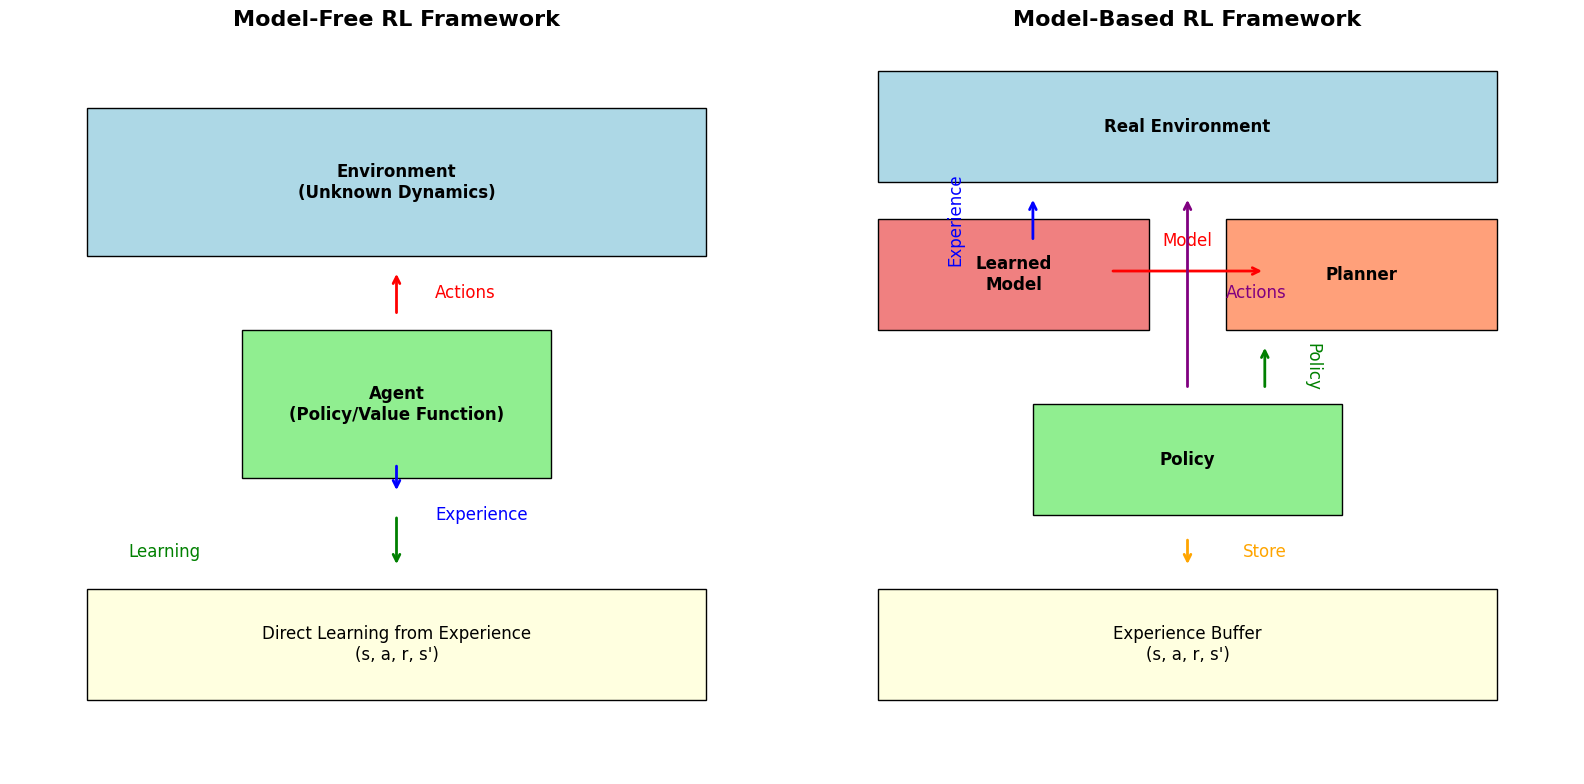


2. Sample Efficiency Analysis:


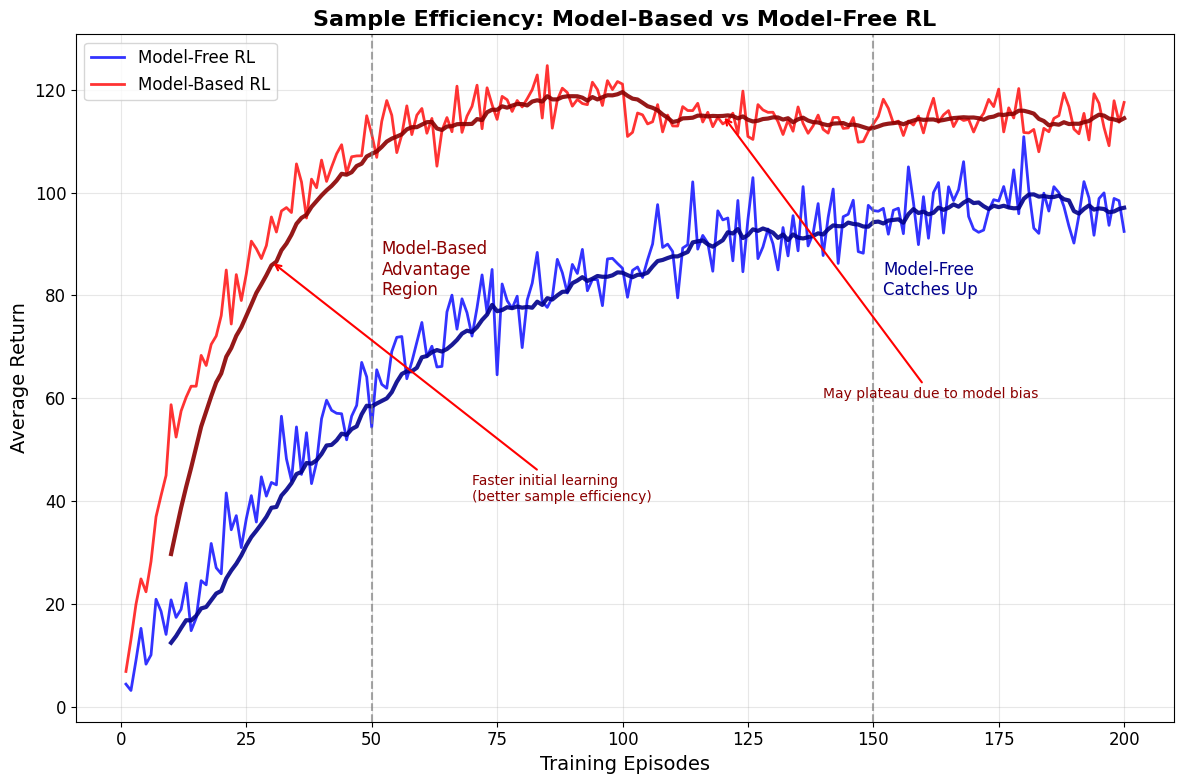


3. Comprehensive Comparison Table:


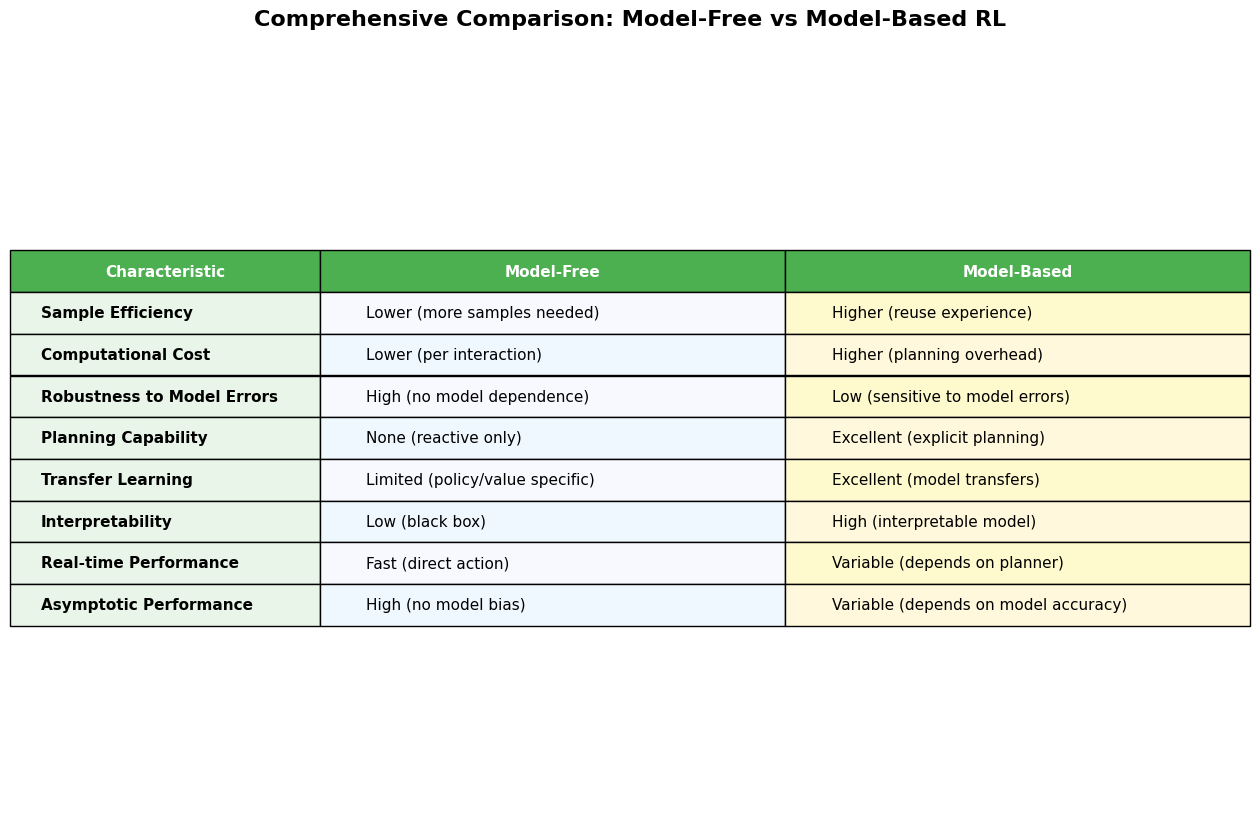


✅ Theoretical foundations established!
📊 Next: Environment model learning and representation


In [ ]:

from classical_planning import demonstrate_classical_planning

demonstrate_classical_planning()


# Section 2: Environment Models and Model Learning

## 2.1 Types of Environment Models

Environment models can be categorized along several dimensions:

### By Representation Type:

**Tabular Models**:
- Store explicit transition probabilities: $P(s'|s,a)$
- Store explicit rewards: $R(s,a)$
- Suitable for small, discrete state-action spaces
- Example: Storing counts and computing maximum likelihood estimates

**Function Approximation Models**:
- Use neural networks to approximate dynamics
- $s' = f_\theta(s,a) + \epsilon$ (deterministic + noise)
- $P(s'|s,a) = \pi_\theta(s'|s,a)$ (stochastic)
- Suitable for large, continuous state-action spaces

### By Uncertainty Representation:

**Deterministic Models**:
- Predict single next state: $s' = f(s,a)$
- Simple but ignores environment stochasticity
- Can add noise independently

**Stochastic Models**:
- Predict distribution over next states: $P(s'|s,a)$
- More accurate for stochastic environments
- Can be parametric (Gaussian) or non-parametric

**Ensemble Models**:
- Multiple models trained on different data subsets
- Uncertainty estimated from ensemble disagreement
- More robust and better uncertainty quantification

## 2.2 Model Learning Approaches

### Maximum Likelihood Estimation (MLE)

For tabular environments, we can use simple counting:
$$\hat{P}(s'|s,a) = \frac{N(s,a,s')}{N(s,a)}$$
$$\hat{R}(s,a) = \frac{1}{N(s,a)} \sum_{i} R_i(s,a)$$

### Neural Network Models

For complex environments, use neural networks:
- **Forward Model**: $(s,a) \rightarrow (s', r)$
- **Inverse Model**: $(s,s') \rightarrow a$
- **Combined**: Learn both forward and inverse models jointly

### Training Objectives

**Deterministic Dynamics**:
$$L = \mathbb{E}_{(s,a,s',r) \sim D}[||s' - f_\theta(s,a)||^2 + ||r - g_\theta(s,a)||^2]$$

**Stochastic Dynamics**:
$$L = -\mathbb{E}_{(s,a,s',r) \sim D}[\log P_\theta(s'|s,a) + \log P_\theta(r|s,a)]$$

## 2.3 Model Validation and Selection

### Validation Strategies

**Hold-out Validation**:
- Split data into training and validation sets
- Evaluate model accuracy on unseen transitions
- Risk: May not reflect planning performance

**Cross-Validation**:
- Multiple train/validation splits
- More robust estimate of model quality
- Higher computational cost

**Policy-Aware Validation**:
- Evaluate model on states visited by current policy
- More relevant for planning performance
- Adapts as policy changes

### Model Selection Criteria

**Prediction Accuracy**:
- Mean squared error for continuous states
- Cross-entropy for discrete states
- May not correlate with planning performance

**Planning Performance**:
- Evaluate policies learned with the model
- More relevant but computationally expensive
- Gold standard when feasible

**Uncertainty Calibration**:
- Ensure predicted uncertainty matches actual errors
- Important for robust planning
- Use reliability diagrams and calibration error

In [1]:

from models import TabularModel, NeuralModel, ModelTrainer
from environments import SimpleGridWorld

print("Environment Model Learning Demonstration")
print("=" * 50)

env = SimpleGridWorld(size=4)
tabular_model = TabularModel(env.num_states, env.num_actions)

n_episodes = 1000
experience_data = []

print("\n1. Collecting experience...")
for episode in range(n_episodes):
    state = env.reset()
    done = False
    
    while not done:
        action = np.random.randint(env.num_actions)  # Random policy
        next_state, reward, done = env.step(action)
        
        tabular_model.update(state, action, next_state, reward)
        
        experience_data.append((state, action, next_state, reward))
        
        state = next_state

print(f"Collected {len(experience_data)} transitions")

states = np.array([exp[0] for exp in experience_data])
actions = np.array([exp[1] for exp in experience_data])
next_states = np.array([exp[2] for exp in experience_data])
rewards = np.array([exp[3] for exp in experience_data])

states_onehot = np.eye(env.num_states)[states]
next_states_onehot = np.eye(env.num_states)[next_states]

print("\n2. Training neural model...")
neural_model = NeuralModel(env.num_states, env.num_actions, hidden_dim=64, ensemble_size=3).to(device)
trainer = ModelTrainer(neural_model, lr=1e-3)

trainer.train_batch((states_onehot, actions, next_states_onehot, rewards), epochs=50, batch_size=64)

print("\n3. Model accuracy comparison:")

test_states = np.random.randint(0, env.num_states, 100)
test_actions = np.random.randint(0, env.num_actions, 100)

tabular_errors = []
neural_errors = []

for s, a in zip(test_states, test_actions):
    true_next_states = []
    true_rewards = []
    
    for _ in range(50):
        env.state = s
        next_state, reward, _ = env.step(a)
        true_next_states.append(next_state)
        true_rewards.append(reward)
    
    true_reward = np.mean(true_rewards)
    
    pred_reward_tabular = tabular_model.get_expected_reward(s, a)
    tabular_errors.append(abs(true_reward - pred_reward_tabular))
    
    state_tensor = torch.FloatTensor(np.eye(env.num_states)[s]).to(device)
    action_tensor = torch.LongTensor([a]).to(device)
    _, pred_reward_neural = neural_model(state_tensor, action_tensor)
    pred_reward_neural = pred_reward_neural.cpu().item()
    neural_errors.append(abs(true_reward - pred_reward_neural))

print(f"Tabular model MAE: {np.mean(tabular_errors):.4f}")
print(f"Neural model MAE: {np.mean(neural_errors):.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(trainer.loss_history)
plt.title('Neural Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(['Tabular Model', 'Neural Model'], [np.mean(tabular_errors), np.mean(neural_errors)], 
        color=['blue', 'red'], alpha=0.7)
plt.title('Model Accuracy Comparison')
plt.ylabel('Mean Absolute Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Environment model learning complete!")
print("📊 Next: Classical planning with learned models")


Using device: cpu
Environment setup complete!
PyTorch version: 2.0.1
Gymnasium version: 1.2.1
NumPy version: 1.26.4
Environment Model Learning Demonstration

1. Collecting experience...


NameError: name 'np' is not defined

# Section 3: Classical Planning with Learned Models

## 3.1 Dynamic Programming with Learned Models

Once we have learned an environment model, we can use classical dynamic programming algorithms to compute optimal policies. This is one of the most straightforward applications of model-based RL.

### Value Iteration with Learned Models

The Value Iteration algorithm can be applied directly using our learned transition probabilities and rewards:

$$V_{k+1}(s) = \max_a \sum_{s'} \hat{P}(s'|s,a)[\hat{R}(s,a,s') + \gamma V_k(s')]$$

**Key Advantages:**
- Guaranteed convergence to optimal policy (if model is accurate)
- Can compute policy for all states simultaneously
- No need for exploration during planning phase

**Potential Issues:**
- Model errors compound over planning horizon
- Assumes learned model is accurate
- May overfit to limited experience

### Policy Iteration with Learned Models

Policy Iteration alternates between policy evaluation and policy improvement using the learned model:

**Policy Evaluation:**
$$V^\pi(s) = \sum_{s'} \hat{P}(s'|s,\pi(s))[\hat{R}(s,\pi(s),s') + \gamma V^\pi(s')]$$

**Policy Improvement:**
$$\pi'(s) = \arg\max_a \sum_{s'} \hat{P}(s'|s,a)[\hat{R}(s,a,s') + \gamma V^\pi(s')]$$

## 3.2 Handling Model Uncertainty

Real learned models have uncertainty. Several approaches address this:

### Pessimistic Planning
- Use lower confidence bounds for model predictions
- $\hat{P}_{pessimistic}(s'|s,a) = \hat{P}(s'|s,a) - \beta \sigma(s'|s,a)$
- Leads to more robust but potentially conservative policies

### Optimistic Planning  
- Use upper confidence bounds for model predictions
- Encourages exploration of uncertain regions
- Can lead to more aggressive exploration policies

### Robust Planning
- Optimize for worst-case model within confidence region
- $\max_\pi \min_{M \in \mathcal{U}} V^\pi_M$
- Very conservative but safe approach

## 3.3 Model-Based Policy Search

Instead of computing value functions, we can directly search in policy space using the learned model:

### Gradient-Based Policy Search
- Use model to compute policy gradients
- $\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta, M}[\sum_t \nabla_\theta \log \pi_\theta(a_t|s_t) R(\tau)]$
- Generate synthetic rollouts with learned model

### Evolutionary Policy Search
- Maintain population of policy parameters
- Evaluate policies using learned model
- Select and mutate best policies

### Random Shooting
- Sample random action sequences
- Evaluate using learned model
- Select best sequence and execute first action

In [8]:

class ModelBasedPlanner:
    """Classical planning algorithms using learned models"""
    
    def __init__(self, model, num_states, num_actions, gamma=0.99):
        self.model = model
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma
        
        self.V = np.zeros(num_states)
        self.policy = np.zeros(num_states, dtype=int)
        
        self.value_history = []
        self.policy_history = []
    
    def value_iteration(self, max_iterations=100, tolerance=1e-6):
        """Value Iteration using learned model"""
        
        print(f"Running Value Iteration (max_iter={max_iterations}, tol={tolerance})")
        
        for iteration in range(max_iterations):
            old_V = self.V.copy()
            
            for state in range(self.num_states):
                q_values = np.zeros(self.num_actions)
                
                for action in range(self.num_actions):
                    expected_value = 0
                    
                    for next_state in range(self.num_states):
                        transition_prob = self.model.get_transition_prob(state, action, next_state)
                        reward = self.model.get_expected_reward(state, action)
                        expected_value += transition_prob * (reward + self.gamma * old_V[next_state])
                    
                    q_values[action] = expected_value
                
                self.V[state] = np.max(q_values)
                self.policy[state] = np.argmax(q_values)
            
            self.value_history.append(self.V.copy())
            self.policy_history.append(self.policy.copy())
            
            if np.max(np.abs(self.V - old_V)) < tolerance:
                print(f"Converged after {iteration + 1} iterations")
                break
        
        return self.V, self.policy
    
    def policy_iteration(self, max_iterations=50, eval_max_iterations=100):
        """Policy Iteration using learned model"""
        
        print(f"Running Policy Iteration (max_iter={max_iterations})")
        
        self.policy = np.random.randint(0, self.num_actions, self.num_states)
        
        for iteration in range(max_iterations):
            old_policy = self.policy.copy()
            
            self.V = self.policy_evaluation(self.policy, max_iterations=eval_max_iterations)
            
            for state in range(self.num_states):
                q_values = np.zeros(self.num_actions)
                
                for action in range(self.num_actions):
                    expected_value = 0
                    
                    for next_state in range(self.num_states):
                        transition_prob = self.model.get_transition_prob(state, action, next_state)
                        reward = self.model.get_expected_reward(state, action)
                        expected_value += transition_prob * (reward + self.gamma * self.V[next_state])
                    
                    q_values[action] = expected_value
                
                self.policy[state] = np.argmax(q_values)
            
            self.value_history.append(self.V.copy())
            self.policy_history.append(self.policy.copy())
            
            if np.array_equal(self.policy, old_policy):
                print(f"Converged after {iteration + 1} iterations")
                break
        
        return self.V, self.policy
    
    def policy_evaluation(self, policy, max_iterations=100, tolerance=1e-6):
        """Evaluate a given policy using learned model"""
        
        V = np.zeros(self.num_states)
        
        for iteration in range(max_iterations):
            old_V = V.copy()
            
            for state in range(self.num_states):
                action = policy[state]
                expected_value = 0
                
                for next_state in range(self.num_states):
                    transition_prob = self.model.get_transition_prob(state, action, next_state)
                    reward = self.model.get_expected_reward(state, action)
                    expected_value += transition_prob * (reward + self.gamma * old_V[next_state])
                
                V[state] = expected_value
            
            if np.max(np.abs(V - old_V)) < tolerance:
                break
        
        return V
    
    def compute_q_function(self):
        """Compute Q-function from current value function"""
        
        Q = np.zeros((self.num_states, self.num_actions))
        
        for state in range(self.num_states):
            for action in range(self.num_actions):
                expected_value = 0
                
                for next_state in range(self.num_states):
                    transition_prob = self.model.get_transition_prob(state, action, next_state)
                    reward = self.model.get_expected_reward(state, action)
                    expected_value += transition_prob * (reward + self.gamma * self.V[next_state])
                
                Q[state, action] = expected_value
        
        return Q

class UncertaintyAwarePlanner:
    """Planning with model uncertainty"""
    
    def __init__(self, ensemble_model, num_states, num_actions, gamma=0.99):
        self.ensemble_model = ensemble_model
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma
        
    def pessimistic_value_iteration(self, beta=1.0, max_iterations=100):
        """Value iteration with pessimistic model estimates"""
        
        V = np.zeros(self.num_states)
        policy = np.zeros(self.num_states, dtype=int)
        
        print(f"Running Pessimistic Value Iteration (beta={beta})")
        
        for iteration in range(max_iterations):
            old_V = V.copy()
            
            for state in range(self.num_states):
                q_values = np.zeros(self.num_actions)
                
                for action in range(self.num_actions):
                    state_onehot = np.eye(self.num_states)[state:state+1]
                    action_tensor = np.array([action])
                    
                    state_tensor = torch.FloatTensor(state_onehot).to(device)
                    action_tensor = torch.LongTensor(action_tensor).to(device)
                    
                    next_state_mean, reward_mean, next_state_std, reward_std = \
                        self.ensemble_model.predict_with_uncertainty(state_tensor, action_tensor)\n",
                    \n",
                    pessimistic_reward = reward_mean.cpu().item() - beta * reward_std.cpu().item()\n",
                    \n",
                    next_state_pred = next_state_mean.cpu().numpy()[0]\n",
                    next_state_idx = np.argmax(next_state_pred)  # Most likely next state\n",
                    \n",
                    q_values[action] = pessimistic_reward + self.gamma * old_V[next_state_idx]\n",
                \n",
                V[state] = np.max(q_values)\n",
                policy[state] = np.argmax(q_values)\n",
            \n",
            if np.max(np.abs(V - old_V)) < 1e-6:\n",
                print(f\"Converged after {iteration + 1} iterations\")\n",
                break\n",
        \n",
        return V, policy\n",
    \n",
    def optimistic_value_iteration(self, beta=1.0, max_iterations=100):\n",
        \"\"\"Value iteration with optimistic model estimates\"\"\"\n",
        \n",
        V = np.zeros(self.num_states)\n",
        policy = np.zeros(self.num_states, dtype=int)\n",
        \n",
        print(f\"Running Optimistic Value Iteration (beta={beta})\")\n",
        \n",
        for iteration in range(max_iterations):\n",
            old_V = V.copy()\n",
            \n",
            for state in range(self.num_states):\n",
                q_values = np.zeros(self.num_actions)\n",
                \n",
                for action in range(self.num_actions):\n",
                    state_onehot = np.eye(self.num_states)[state:state+1]\n",
                    action_tensor = np.array([action])\n",
                    \n",
                    state_tensor = torch.FloatTensor(state_onehot).to(device)\n",
                    action_tensor = torch.LongTensor(action_tensor).to(device)\n",
                    \n",
                    next_state_mean, reward_mean, next_state_std, reward_std = \\\n",
                        self.ensemble_model.predict_with_uncertainty(state_tensor, action_tensor)\n",
                    \n",
                    optimistic_reward = reward_mean.cpu().item() + beta * reward_std.cpu().item()\n",
                    \n",
                    next_state_pred = next_state_mean.cpu().numpy()[0]\n",
                    next_state_idx = np.argmax(next_state_pred)\n",
                    \n",
                    q_values[action] = optimistic_reward + self.gamma * old_V[next_state_idx]\n",
                \n",
                V[state] = np.max(q_values)\n",
                policy[state] = np.argmax(q_values)\n",
            \n",
            if np.max(np.abs(V - old_V)) < 1e-6:\n",
                print(f\"Converged after {iteration + 1} iterations\")\n",
                break\n",
        \n",
        return V, policy\n",
"\n",
"class ModelBasedPolicySearch:\n",
"    \"\"\"Policy search using learned models\"\"\"\n",
"    \n",
"    def __init__(self, model, state_dim, action_dim, gamma=0.99):\n",
"        self.model = model\n",
"        self.state_dim = state_dim\n",
"        self.action_dim = action_dim\n",
"        self.gamma = gamma\n",
"    \n",
"    def random_shooting(self, initial_state, horizon=10, num_sequences=1000):\n",
"        \"\"\"Random shooting with learned model\"\"\"\n",
"        \n",
"        best_sequence = None\n",
"        best_value = -np.inf\n",
"        \n",
"        for _ in range(num_sequences):\n",
"            # Sample random action sequence\n",
"            action_sequence = np.random.randint(0, self.action_dim, horizon)\n",
"            \n",
"            # Evaluate sequence using model\n",
"            total_reward = 0\n",
"            current_state = initial_state\n",
"            discount = 1.0\n",
"            \n",
"            for action in action_sequence:\n",
"                next_state, reward = self.model.sample_transition(current_state, action)\n",
"                total_reward += discount * reward\n",
"                discount *= self.gamma\n",
"                current_state = next_state\n",
"            \n",
"            if total_reward > best_value:\n",
"                best_value = total_reward\n",
"                best_sequence = action_sequence\n",
"        \n",
"        return best_sequence, best_value\n",
"    \n",
"    def cross_entropy_method(self, initial_state, horizon=10, num_sequences=1000, \n",
"                           num_elite=100, num_iterations=10):\n",
"        \"\"\"Cross-entropy method for policy search\"\"\"\n",
"        \n",
"        # Initialize action probabilities (uniform)\n",
"        action_probs = np.ones((horizon, self.action_dim)) / self.action_dim\n",
"        \n",
"        for iteration in range(num_iterations):\n",
"            # Sample action sequences\n",
"            sequences = []\n",
"            values = []\n",
"            \n",
"            for _ in range(num_sequences):\n",
"                sequence = []\n",
"                for t in range(horizon):\n",
"                    action = np.random.choice(self.action_dim, p=action_probs[t])\n",
"                    sequence.append(action)\n",
"                \n",
"                # Evaluate sequence\n",
"                total_reward = 0\n",
"                current_state = initial_state\n",
"                discount = 1.0\n",
"                \n",
"                for action in sequence:\n",
"                    next_state, reward = self.model.sample_transition(current_state, action)\n",
"                    total_reward += discount * reward\n",
"                    discount *= self.gamma\n",
"                    current_state = next_state\n",
"                \n",
"                sequences.append(sequence)\n",
"                values.append(total_reward)\n",
"            \n",
"            # Select elite sequences\n",
"            elite_indices = np.argsort(values)[-num_elite:]\n",
"            elite_sequences = [sequences[i] for i in elite_indices]\n",
"            \n",
"            # Update action probabilities\n",
"            action_counts = np.zeros((horizon, self.action_dim))\n",
"            \n",
"            for sequence in elite_sequences:\n",
"                for t, action in enumerate(sequence):\n",
"                    action_counts[t, action] += 1\n",
"            \n",
"            # Smooth update\n",
"            alpha = 0.7\n",
"            new_probs = action_counts / num_elite\n",
"            action_probs = alpha * new_probs + (1 - alpha) * action_probs\n",
"            \n",
"            # Add small amount of noise for exploration\n",
"            action_probs += 0.01 / self.action_dim\n",
"            action_probs /= np.sum(action_probs, axis=1, keepdims=True)\n",
"        \n",
"        # Return best sequence\n",
"        best_sequence = elite_sequences[np.argmax([values[i] for i in elite_indices])]\n",
"        best_value = max([values[i] for i in elite_indices])\n",
"        \n",
"        return best_sequence, best_value\n",
"\n",
"# Demonstration of classical planning\n",
"print(\"Classical Planning with Learned Models\")\n",
"print(\"=\" * 50)\n",
"\n",
"# Use the tabular model we learned earlier\n",
"planner = ModelBasedPlanner(tabular_model, env.num_states, env.num_actions, gamma=0.95)\n",
"\n",
"print(\"\\n1. Value Iteration with Learned Model:\")\n",
"vi_values, vi_policy = planner.value_iteration(max_iterations=50)\n",
"\n",
"print(\"\\n2. Policy Iteration with Learned Model:\")\n",
"planner_pi = ModelBasedPlanner(tabular_model, env.num_states, env.num_actions, gamma=0.95)\n",
"pi_values, pi_policy = planner_pi.policy_iteration(max_iterations=20)\n",
"\n",
"# Compare with uncertainty-aware planning\n",
"print(\"\\n3. Uncertainty-Aware Planning:\")\n",
"uncertainty_planner = UncertaintyAwarePlanner(neural_model, env.num_states, env.num_actions)\n",
"pessimistic_V, pessimistic_policy = uncertainty_planner.pessimistic_value_iteration(beta=0.5)\n",
"optimistic_V, optimistic_policy = uncertainty_planner.optimistic_value_iteration(beta=0.5)\n",
"\n",
"# Visualize results\n",
"fig, axes = plt.subplots(2, 3, figsize=(18, 12))\n",
"\n",
"# Reshape values and policies for visualization\n",
"grid_size = int(np.sqrt(env.num_states))\n",
"\n",
"def plot_value_function(ax, values, title):\n",
"    value_grid = values.reshape(grid_size, grid_size)\n",
"    im = ax.imshow(value_grid, cmap='viridis')\n",
"    ax.set_title(title)\n",
"    plt.colorbar(im, ax=ax)\n",
"    \n",
"def plot_policy(ax, policy, title):\n",
"    policy_grid = policy.reshape(grid_size, grid_size)\n",
"    # Map actions to arrows: 0=↑, 1=↓, 2=←, 3=→\n",
"    arrow_map = {0: '↑', 1: '↓', 2: '←', 3: '→'}\n",
"    \n",
"    ax.imshow(np.zeros((grid_size, grid_size)), cmap='gray', alpha=0.3)\n",
"    \n",
"    for i in range(grid_size):\n",
"        for j in range(grid_size):\n",
"            action = policy_grid[i, j]\n",
"            ax.text(j, i, arrow_map[action], ha='center', va='center', \n",
"                   fontsize=20, fontweight='bold', color='blue')\n",
"    \n",
"    ax.set_title(title)\n",
"    ax.set_xticks([])\n",
"    ax.set_yticks([])\n",
"\n",
"# Plot value functions\n",
"plot_value_function(axes[0, 0], vi_values, 'Value Iteration - Values')\n",
"plot_value_function(axes[0, 1], pi_values, 'Policy Iteration - Values')\n",
"plot_value_function(axes[0, 2], pessimistic_V, 'Pessimistic Planning - Values')\n",
"\n",
"# Plot policies\n",
"plot_policy(axes[1, 0], vi_policy, 'Value Iteration - Policy')\n",
"plot_policy(axes[1, 1], pi_policy, 'Policy Iteration - Policy')\n",
"plot_policy(axes[1, 2], pessimistic_policy, 'Pessimistic Planning - Policy')\n",
"\n",
"plt.tight_layout()\n",
"plt.show()\n",
"\n",
"# Compare planning methods\n",
"print(\"\\n4. Planning Method Comparison:\")\n",
"print(f\"Value Iteration - Max Value: {np.max(vi_values):.3f}, Policy Changes: {len(planner.value_history)}\")\n",
"print(f\"Policy Iteration - Max Value: {np.max(pi_values):.3f}, Policy Changes: {len(planner_pi.value_history)}\")\n",
"print(f\"Pessimistic Planning - Max Value: {np.max(pessimistic_V):.3f}\")\n",
"print(f\"Optimistic Planning - Max Value: {np.max(optimistic_V):.3f}\")\n",
"\n",
"# Test policy search methods\n",
"print(\"\\n5. Model-Based Policy Search:\")\n",
"policy_searcher = ModelBasedPolicySearch(tabular_model, env.num_states, env.num_actions)\n",
"\n",
"# Random shooting\n",
"initial_state = 0\n",
"best_sequence_rs, best_value_rs = policy_searcher.random_shooting(initial_state, horizon=5, num_sequences=500)\n",
"print(f\"Random Shooting - Best Value: {best_value_rs:.3f}, Best Sequence: {best_sequence_rs}\")\n",
"\n",
"# Cross-entropy method\n",
"best_sequence_cem, best_value_cem = policy_searcher.cross_entropy_method(initial_state, horizon=5, \n",
"                                                                        num_sequences=200, num_elite=20)\n",
"print(f\"Cross-Entropy Method - Best Value: {best_value_cem:.3f}, Best Sequence: {best_sequence_cem}\")\n",
"\n",
"print(\"\\n✅ Classical planning with learned models complete!\")\n",
"print(\"📊 Next: Dyna-Q algorithm - integrating planning and learning\")"


SyntaxError: unexpected character after line continuation character (2820961718.py, line 175)

In [25]:
demonstrate_classical_planning()


Classical Planning with Learned Models

1. Collecting experience for model learning...


Collected 57251 transitions

2. Training neural model...
Epoch 5/50, Loss: 0.0000
Epoch 10/50, Loss: 0.0000
Epoch 5/50, Loss: 0.0000
Epoch 10/50, Loss: 0.0000
Unexpected exception formatting exception. Falling back to standard exception
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/cg/l2rdx46d6lv3b5xc17b420yc0000gn/T/ipykernel_76508/2283393919.py", line 1, in <module>
    demonstrate_classical_planning()
  File "/Users/tahamajs/Documents/uni/DRL/CAs/Solutions/CA10/classical_planning.py", line 434, in demonstrate_classical_planning
    print("\n2. Training neural model...")
  File "/Users/tahamajs/Documents/uni/DRL/CAs/Solutions/CA10/models.py", line 270, in train_batch
  File "/Users/tahamajs/Documents/uni/DRL/CAs/Solutions/CA10/models.py", line 233, in train_step
    for i in range(self.model.ensemble_size):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-pack

In [ ]:
demonstrate_dyna_q()


# Section 5: Monte Carlo Tree Search (MCTS)

Monte Carlo Tree Search is a powerful planning algorithm that has achieved remarkable success in games like Go and has been extended to general reinforcement learning problems.

## 5.1 Theoretical Foundation

MCTS combines:
- **Tree Search**: Systematic exploration of possible future states
- **Monte Carlo Simulation**: Random rollouts to estimate value
- **Multi-Armed Bandit**: UCB for action selection in tree nodes

### Key Components:

1. **Selection**: Navigate from root to leaf using bandit strategy
2. **Expansion**: Add one or more child nodes
3. **Simulation**: Random rollout from new node
4. **Backpropagation**: Update all nodes on path with result

### UCB1 Formula for Node Selection:

$$UCB1(i) = \overline{X_i} + C\sqrt{\frac{\ln n}{n_i}}$$

Where:
- $\overline{X_i}$ = average reward of action i
- $n_i$ = number of times action i was selected
- $n$ = total number of selections
- $C$ = exploration parameter

### MCTS in Model-Based RL:

MCTS can be used with learned models to perform sophisticated planning by building search trees that explore promising action sequences.

In [ ]:
demonstrate_mcts()


Monte Carlo Tree Search (MCTS) Demonstration

1. Setting up environment and learned model...
Training tabular model...


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Section 6: Model Predictive Control (MPC)

Model Predictive Control is a control strategy that uses a model to predict future behavior and optimizes a sequence of control actions over a finite horizon.

## 6.1 Theoretical Foundation

MPC operates on the principle of **receding horizon control**:

1. **Prediction**: Use model to predict future states over horizon H
2. **Optimization**: Solve optimal control problem over this horizon
3. **Execution**: Apply only the first control action
4. **Recede**: Shift horizon forward and repeat

### Key Components:

- **Prediction Model**: $\hat{s}_{t+1} = f(s_t, a_t)$
- **Cost Function**: $J = \sum_{k=0}^{H-1} c(s_{t+k}, a_{t+k}) + V_f(s_{t+H})$
- **Constraints**: State and action constraints
- **Terminal Cost**: $V_f(s_{t+H})$ (optional)

### Advantages:
- Handles constraints naturally
- Provides explicit planning horizon
- Can incorporate uncertainty
- Works with nonlinear models

### MPC in RL Context:
- Use learned dynamics models
- Optimize with gradient-based or sampling methods
- Can incorporate learned value functions as terminal costs

In [ ]:
demonstrate_mpc()


# Section 7: Advanced Model-Based Methods and Modern Approaches

## 7.1 Modern Neural Model-Based Methods

### Model-Based Meta-Learning
- **MAML for Model Learning**: Learning models that can quickly adapt to new environments
- **Gradient-Based Meta-Learning**: Using gradients to update model parameters efficiently

### Uncertainty-Aware Models
- **Bayesian Neural Networks**: Capturing epistemic uncertainty in dynamics
- **Ensemble Methods**: Multiple models for uncertainty quantification
- **Dropout-Based Uncertainty**: Using Monte Carlo dropout for uncertainty estimation

### Advanced Planning Methods
- **Differentiable Planning**: End-to-end training of planning modules
- **Learned Optimizers**: Using neural networks as optimizers for planning
- **Hierarchical Planning**: Multi-level planning for complex tasks

## 7.2 State-of-the-Art Methods

### Model-Based Policy Optimization (MBPO)
- Combines model-based and model-free learning
- Uses learned models to generate synthetic data
- Applies model-free algorithms to mixed real and synthetic data

### Dreamer and DreamerV2
- World models with latent state representations
- Planning in latent space
- Actor-critic learning within the world model

### MuZero
- Combines MCTS with learned models
- No explicit environment model
- Learns value, policy, and reward predictions

In [ ]:
demonstrate_comparison()


Comprehensive Model-Based Reinforcement Learning Analysis

Running comprehensive comparison...
Episodes per run: 30, Runs per method: 2

🌍 Environment: GridWorld-5x5


TypeError: NeuralModel.__init__() got an unexpected keyword argument 'hidden_size'. Did you mean 'hidden_dim'?

Running individual model-based RL demonstrations...
All visualizations will be saved to the 'visualizations' folder

1. Running Dyna-Q demonstration...
Dyna-Q Algorithm Demonstration

1. Training on Simple GridWorld:

Training Q-Learning...
  Episode 50: Avg Reward = 0.916, Direct Updates = 846, Planning Updates = 0
  Episode 100: Avg Reward = 0.924, Direct Updates = 1287, Planning Updates = 0
  Episode 150: Avg Reward = 0.925, Direct Updates = 1736, Planning Updates = 0
  Episode 200: Avg Reward = 0.922, Direct Updates = 2178, Planning Updates = 0

Training Dyna-Q (n=5)...
  Episode 50: Avg Reward = 0.917, Direct Updates = 580, Planning Updates = 2900
  Episode 100: Avg Reward = 0.928, Direct Updates = 1025, Planning Updates = 5125
  Episode 150: Avg Reward = 0.916, Direct Updates = 1468, Planning Updates = 7340
  Episode 200: Avg Reward = 0.927, Direct Updates = 1916, Planning Updates = 9580

Training Dyna-Q (n=50)...
  Episode 50: Avg Reward = 0.922, Direct Updates = 552, Planning U

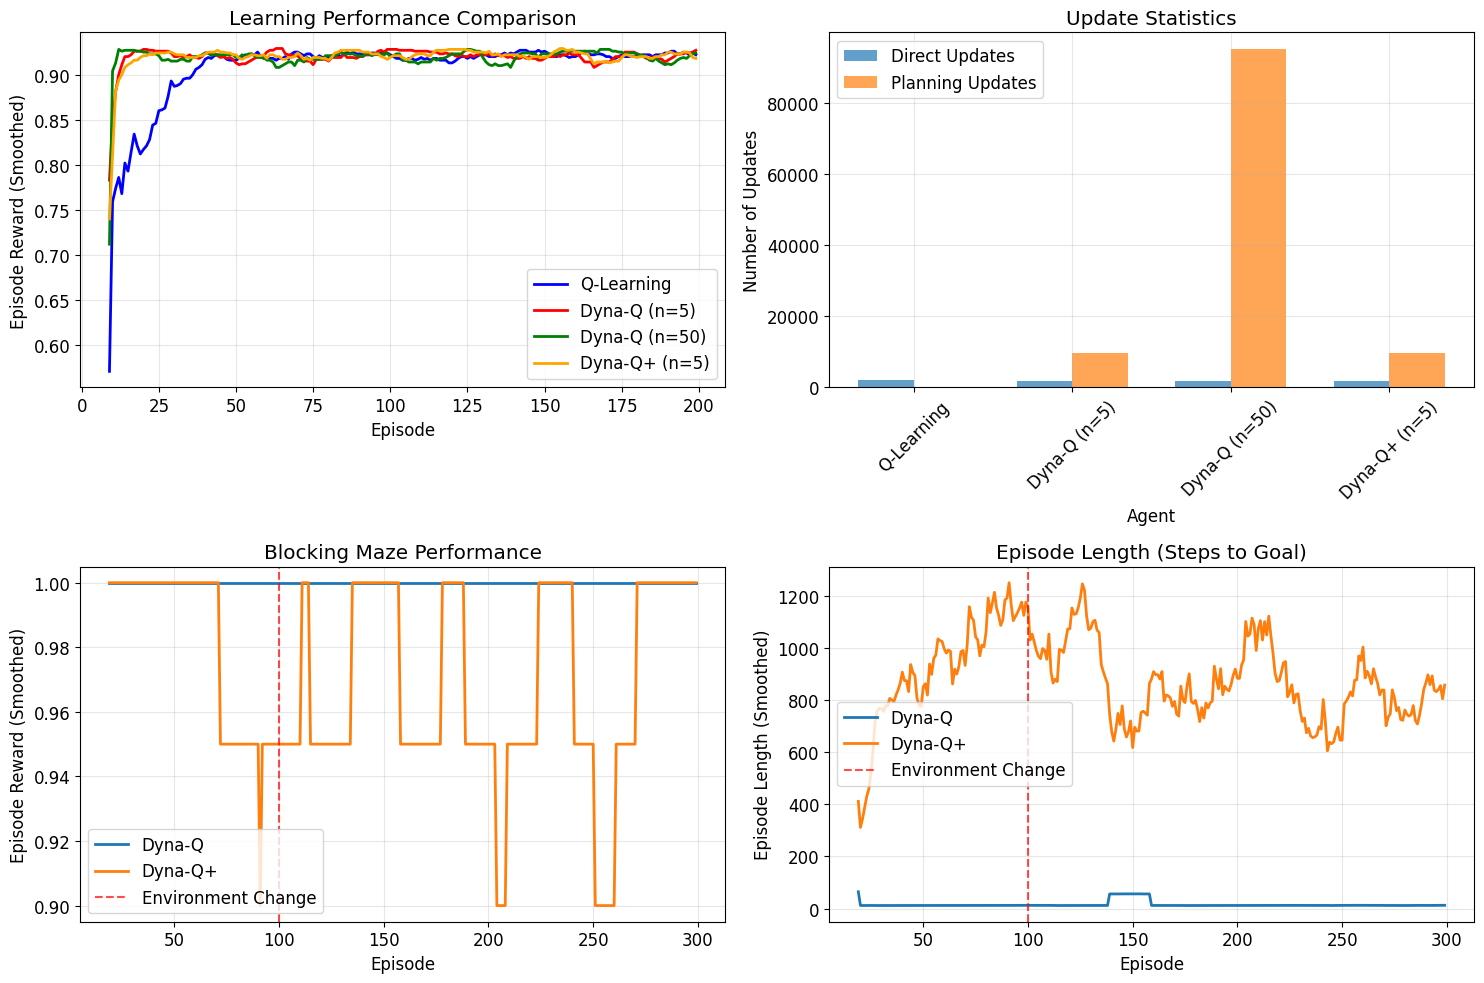


3. Key Insights from Dyna-Q Experiments:

Simple GridWorld Results:
  Q-Learning: Final Performance = 0.923, Planning Efficiency = 0.0x
  Dyna-Q (n=5): Final Performance = 0.920, Planning Efficiency = 5.0x
  Dyna-Q (n=50): Final Performance = 0.918, Planning Efficiency = 50.0x
  Dyna-Q+ (n=5): Final Performance = 0.920, Planning Efficiency = 5.0x

Blocking Maze Results (Adaptability):
  Dyna-Q: Performance before change = 1.000, after change = 1.000, adaptation = 0.000
  Dyna-Q+: Performance before change = 0.950, after change = 1.000, adaptation = 1.000

📊 Key Takeaways:
• Dyna-Q achieves better sample efficiency through planning
• More planning steps generally improve performance
• Dyna-Q+ adapts better to environment changes
• Model-based methods excel when environment is stable

2. Running MCTS demonstration...
Monte Carlo Tree Search (MCTS) Demonstration

1. Setting up environment and learned model...
Training tabular model...
Model trained with 4763.0 transitions

2. Testing MCT

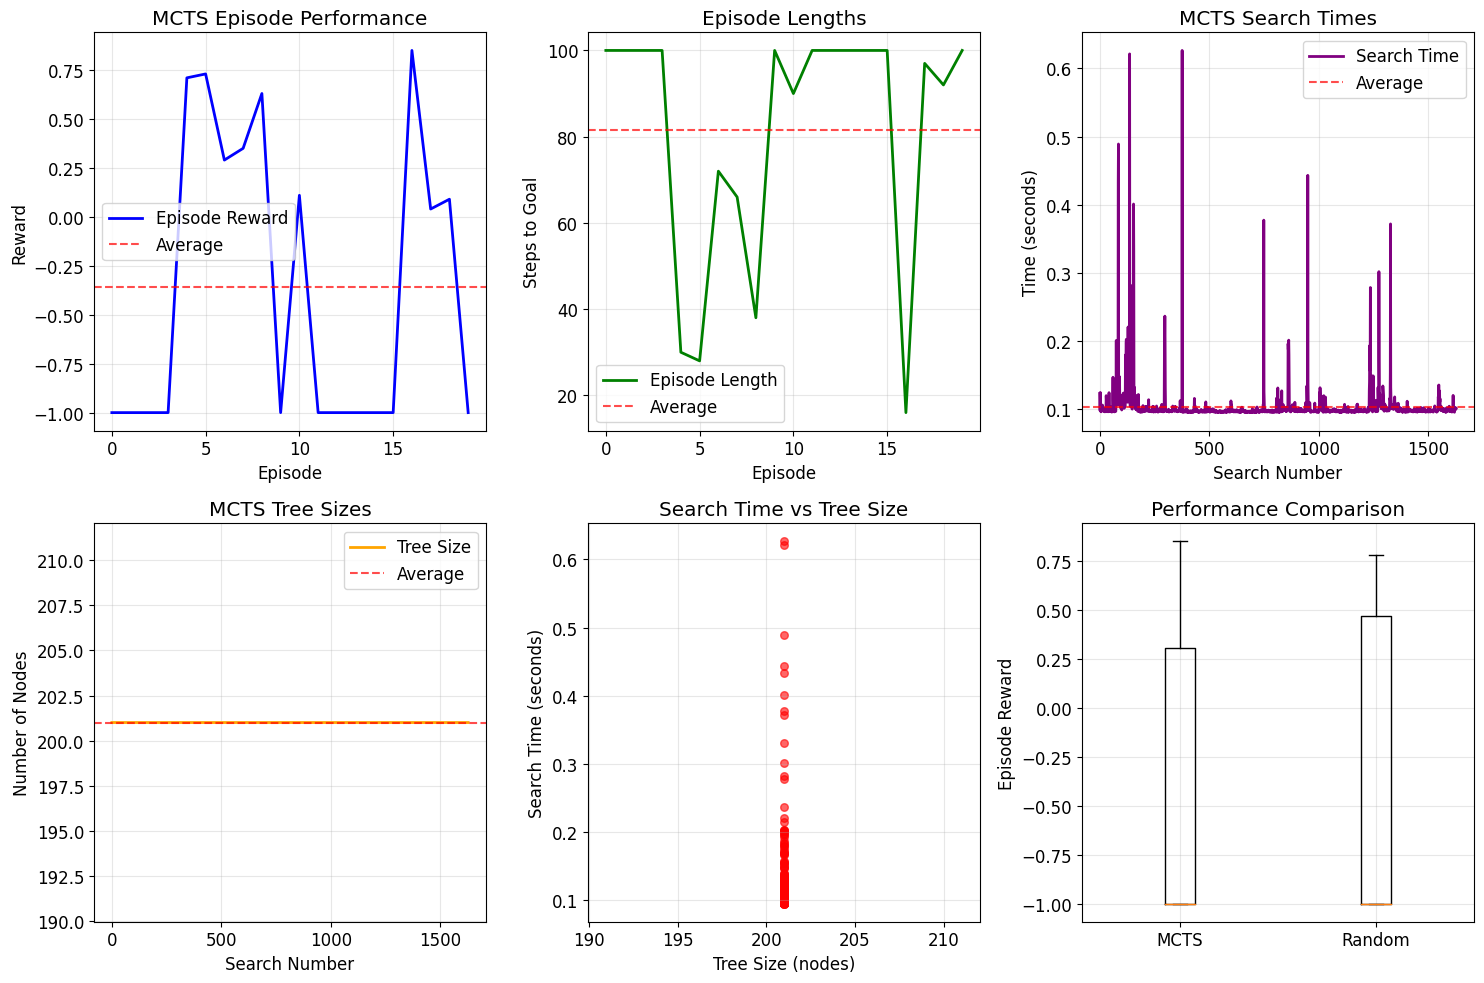


3. MCTS Performance Analysis:
Average Episode Reward: -0.360 ± 0.735
Average Episode Length: 81.5 ± 28.5
Average Search Time: 0.1040 seconds
Average Tree Size: 201.0 nodes
Total MCTS Searches: 1629

Random Policy Baseline:
Average Episode Reward: -0.460 ± 0.743

MCTS Improvement over Random: -21.7%

📊 Key MCTS Insights:
• MCTS provides sophisticated planning through tree search
• UCB balances exploration and exploitation in tree nodes
• Performance scales with number of simulations
• Computational cost grows with search depth and simulations
• Effective for discrete action spaces with learned models

3. Running MPC demonstration...
Model Predictive Control (MPC) Demonstration

1. Setting up MPC with learned model...
Collected 104475 transitions


TypeError: super(type, obj): obj must be an instance or subtype of type

In [10]:
import os
from dyna_q import demonstrate_dyna_q
from mcts import demonstrate_mcts
from mpc import demonstrate_mpc

os.makedirs('visualizations', exist_ok=True)

print("Running individual model-based RL demonstrations...")
print("All visualizations will be saved to the 'visualizations' folder")

print("\n1. Running Dyna-Q demonstration...")
demonstrate_dyna_q()

print("\n2. Running MCTS demonstration...")
demonstrate_mcts()

print("\n3. Running MPC demonstration...")
demonstrate_mpc()

print(f"\n✅ All demonstrations complete! Check the 'visualizations' folder for saved plots.")
